# CDO Ocean/Land Mask


In this notebook we demonstrate how to mask ocean or land:

- Look at the data information
- Create land and ocean masks to limit the field to land/ocean values 
- Visualise data using xarray and hvplot


This example uses the Coupled Model Intercomparison Project (CMIP6) collections. 

---
inspired by the notebook in  https://github.com/NCI-data-analysis-platform/climate-cmip.git
- Original Authors: NCI Virtual Research Environment Team
- Keywords: CMIP, CDO, land mask, ocean mask
- Create Date: 2019-Dec; Update Date: 2021-Feb
---
Adapted to work on the DKRZ jupyterhub environment: S. Kindermann August 2022

This notebook is licenced under the [Creative Commons Attribution 4.0 International license](https://creativecommons.org/licenses/by/4.0/)

### Load CDO module

To load the CDO module on the VDI, run:

``` $ module load cdo```

### CMIP6 data

The following example file includes the near surface temperature from the 20th century all-forcing historical simulation based on the CESM2.0 model of NCAR. 

In [1]:
!ls /pool/data/CMIP6/data/CMIP/NCAR/CESM2/historical/r1i1p1f1/Amon/tas/gn/v20190308/tas_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc

/pool/data/CMIP6/data/CMIP/NCAR/CESM2/historical/r1i1p1f1/Amon/tas/gn/v20190308/tas_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc


### Have a look at the data file using cdo info

Basic usage: **cdo info filename | head -xx**

**head** displays only the first lines of the output (in this case xx lines)

In [2]:
 !cdo info /pool/data/CMIP6/data/CMIP/NCAR/CESM2/historical/r1i1p1f1/Amon/tas/gn/v20190308/tas_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc| head -15

    -1 :       Date     Time   Level Gridsize    Miss :     Minimum        Mean     Maximum : Parameter ID
     1 : 1850-01-15 12:00:00       0    55296       0 :      230.23      276.17      308.85 : -1            
     2 : 1850-02-14 00:00:00       0    55296       0 :      225.95      275.52      308.40 : -1            
     3 : 1850-03-15 12:00:00       0    55296       0 :      218.57      275.34      306.48 : -1            
     4 : 1850-04-15 00:00:00       0    55296       0 :      214.40      276.61      308.30 : -1            
     5 : 1850-05-15 12:00:00       0    55296       0 :      212.68      278.50      311.07 : -1            
     6 : 1850-06-15 00:00:00       0    55296       0 :      208.08      279.65      312.28 : -1            
     7 : 1850-07-15 12:00:00       0    55296       0 :      207.78      279.77      314.52 : -1            
     8 : 1850-08-15 12:00:00       0    55296       0 :      208.03      279.31      313.39 : -1            
     9 : 1850-09-15 0

### Let's see which years this file includes

We use the function **showyear** to display all the years in this file.

**Basic usage**: **cdo showyear file**

In [3]:
!cdo showyear /pool/data/CMIP6/data/CMIP/NCAR/CESM2/historical/r1i1p1f1/Amon/tas/gn/v20190308/tas_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc

 1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861 1862 1863 1864 1865 1866 1867 1868 1869
 1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889
 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909
 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929
 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949
 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969
 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989
 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014
cdo    showyear: Processed 1 variable over 1980 timesteps [0.07s 50MB].


### Create topography data 

```
$ cdo -f <format of the output file (e.g. nc/grb/srv/ext/ieg)> topo topo.nc
```
The operator topo creates a half degree regular grid with heights and depths. This can be very useful for generating masks to a certain height/depth.

In [4]:
### create output directory if it doesn't already exist
import os
outdir = './output'
if not os.path.exists(outdir):
    os.mkdir(outdir)

!cdo -f nc topo ./output/topo.nc 

cdo    topo:  [0.02s 50MB].


Let's visualise our topo.nc file in xarray

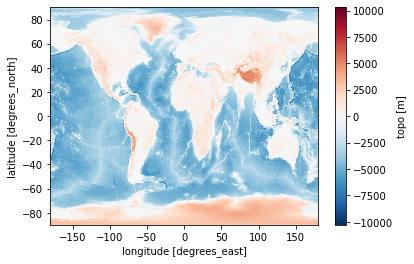

In [5]:
import xarray as xr 
topo= xr.open_dataset("./output/topo.nc")
topo.topo.plot()              

From our topo.nc file we can observe that the topography values over land areas are greater than 0 whereas over ocean areas the topography are less than 0.

### Create ocean mask file

**Basic usage**: 

```cdo gtc, 0 -remapcon, input.nc topo.nc output.nc```


There are several steps involved in here:

First, remapping the topo.nc file to change its resolution so that it is consistent with the input data that we use: 

```
$ cdo -remapcon,/pool/data/CMIP6/data/CMIP/NCAR/CESM2/historical/r1i1p1f1/Amon/tas/gn/v20190308/tas_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc ./output/topo.nc ./output/topo_adjusted.nc
```

Second, create a mask containing 1 if the topography element is greater than 0: 
```
$ cdo gtc,0 topo_adjusted.nc seamask.nc
```

### Now we will try to chain all the commands together

**Basic Usage:** 

```cdo -f <file_type> -gtc,0 -remapcon,<input.nc> -topo <output.nc>```


In [6]:
!cdo -f nc -gtc,0 -remapcon,/pool/data/CMIP6/data/CMIP/NCAR/CESM2/historical/r1i1p1f1/Amon/tas/gn/v20190308/tas_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc -topo ./output/seamask.nc

cdo(1) remapcon: Process started
cdo(2) topo: Process started
cdo(1) remapcon: YAC first order conservative weights from lonlat (720x360) to lonlat (288x192) grid
cdo(1) remapcon:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo(2) topo: 
cdo(1) remapcon: Processed 259200 values from 1 variable over 1 timestep.
cdo    gtc: Processed 55296 values from 1 variable over 1 timestep [1.03s 183MB].


**Similarly, we can get land mask using the following command:**

```cdo -f <file_type> -lec,0 -remapcon,<input.nc> -topo <output.nc>```

In [7]:
!cdo -f nc -lec,0 -remapcon,/pool/data/CMIP6/data/CMIP/NCAR/CESM2/historical/r1i1p1f1/Amon/tas/gn/v20190308/tas_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc -topo ./output/landmask.nc

cdo(1) remapcon: Process started
cdo(2) topo: Process started
cdo(1) remapcon: YAC first order conservative weights from lonlat (720x360) to lonlat (288x192) grid
cdo(1) remapcon:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo(2) topo: 
cdo(1) remapcon: Processed 259200 values from 1 variable over 1 timestep.
cdo    lec: Processed 55296 values from 1 variable over 1 timestep [1.03s 183MB].


### Let's have a look at what the generated seamask.nc looks like

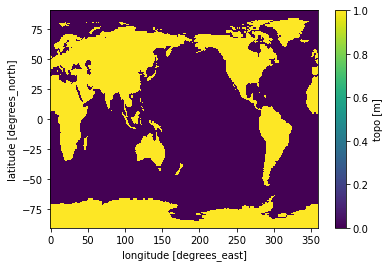

In [8]:
sea = xr.open_dataset("./output/seamask.nc")
sea.topo.plot()

From our topography file, we can see that all ocean values are 0 and all land values are 1.

### Now we can apply the seamask to the original data to mask out ocean data

Multiply input.nc and seamask, and the ocean values in output.nc all become zero.

```cdo mul <input.nc> <seamask.nc> <output.nc>```

Set zero as the missing value in the data:

```cdo setmissval,0 <input.nc> <output.nc>```


To combine these two commands together:

```cdo setmissval,0 -mul <input.nc> <seamask.nc> <output.nc>**```
``` 

Warning: Be cautious when using zero as the missing value in case zero has already been used as a reasonable element in the original data. In this example, the data use Kelvin(K) as the unit of temperature and therefore using zero as the missing value is not an issue as 0deg K cannot be interpreted as a reasonable Earth near surface temperature.

In [9]:
!cdo setmissval,0 -mul /pool/data/CMIP6/data/CMIP/NCAR/CESM2/historical/r1i1p1f1/Amon/tas/gn/v20190308/tas_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc ./output/seamask.nc ./output/tas_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412_land.nc

cdo(1) mul: Process started
cdo(1) mul: Filling up stream2 >./output/seamask.nc< by copying the first timestep.
cdo(1) mul: Processed 109541376 values from 2 variables over 1981 timesteps.
cdo    setmissval: Processed 109486080 values from 1 variable over 1980 timesteps [2.22s 186MB].


### Let's have a look at the new land data file

In [2]:
# to do: ncview shows nice plot .. :-)
import xarray as xr
import hvplot.xarray
land = xr.open_dataset("./output/tas_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412_land.nc")

#land.tas.isel(time=0).plot()
land.tas.hvplot.quadmesh(width=600)

:DynamicMap   [time]
   :QuadMesh   [lon,lat]   (tas)

### Summary

In this example, we show how to use CDO to create land/ocean masks when we only need to visualize the ocean/land data.

## Reference

https://code.zmaw.de/projects/cdo/embedded/cdo.pdf
